This notebook is simpified version of the final project in the [How to Win a Data Science Competition: Learn from Top Kagglers](https://www.coursera.org/learn/competitive-data-science) course. Simplified means without ensembling.

#### Pipline
* load data
* heal data and remove outliers
* work with shops/items/cats objects and features
* create matrix as product of item/shop pairs within each month in the train set
* get monthly sales for each item/shop pair in the train set and merge it to the matrix
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats to the matrix
* add target lag features
* add mean encoded features
* add price trend features
* add month
* add days
* add months since last sale/months since first sale features
* cut first year and drop columns which can not be calculated for the test set
* select best features
* set validation strategy 34 test, 33 validation, less than 33 train
* fit the model, predict and clip targets for the test set

# Part 1, perfect features

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)

In [4]:
'''items = pd.read_csv('../input/items.csv')
shops = pd.read_csv('../input/shops.csv')
cats = pd.read_csv('../input/item_categories.csv')
train = pd.read_csv('../input/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('../input/test.csv').set_index('ID')'''

# loading datasets
items = pd.read_csv(r'C:\Users\Abhishek\Documents\Predict future sales\Data\items.csv')
shops = pd.read_csv(r'C:\Users\Abhishek\Documents\Predict future sales\Data\shops.csv')
cats = pd.read_csv(r'C:\Users\Abhishek\Documents\Predict future sales\Data\item_categories.csv')
train = pd.read_csv(r'C:\Users\Abhishek\Documents\Predict future sales\Data\sales_train.csv', parse_dates=['date'])
# set index to ID to avoid droping it later
test  = pd.read_csv(r'C:\Users\Abhishek\Documents\Predict future sales\Data\test.csv').set_index('ID')

# EDA

In [5]:
#shape of dataset
print('The shape of items dataset is',items.shape)
print('The shape of shops dataset is',shops.shape)
print('The shape of cats dataset is',cats.shape)
print('The shape of train dataset is',train.shape)
print('The shape of test dataset is',test.shape)

The shape of items dataset is (22170, 3)
The shape of shops dataset is (60, 2)
The shape of cats dataset is (84, 2)
The shape of train dataset is (2935849, 6)
The shape of test dataset is (214200, 2)


# quick view of the dataset

In [6]:
print('items')
items.head()

items


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [8]:
items.nunique()

item_name           22170
item_id             22170
item_category_id       84
dtype: int64

In [9]:
pd.value_counts(items['item_category_id'] )

40    5035
55    2365
37    1780
31    1125
58     790
30     756
72     666
19     628
61     598
23     501
43     471
57     427
56     397
67     394
63     366
76     333
41     332
69     317
38     310
62     295
59     294
64     290
78     278
75     277
28     240
70     228
77     220
45     195
66     178
20     175
49     167
65     163
44     161
47     151
25     140
21     125
24     123
54      90
22      79
2       75
60      52
29      46
11      41
6       40
15      37
73      36
3       34
5       29
68      27
7       24
12      20
16      20
33      18
14      18
4       15
83      15
42      12
9       12
46      12
8        9
82       8
34       8
27       8
74       8
17       7
81       7
39       7
71       6
36       6
32       6
80       6
18       6
13       6
48       5
0        4
35       4
52       3
53       3
26       3
50       2
1        2
51       1
10       1
79       1
Name: item_category_id, dtype: int64

In [10]:
np.sort(items.item_category_id.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83],
      dtype=int64)

- There is no null values in items dataset
- There are 22170 items listed under 84 categories
- The category ids are from 0 to 83
- The largest no. of items are in category_id 40.

In [11]:
print('shops')
shops.head()

shops


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [12]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [13]:
shops.nunique()

shop_name    60
shop_id      60
dtype: int64

In [14]:
np.sort(shops.shop_id.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int64)

In [15]:
shops.shop_name.unique()

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва Т

In [16]:
#import the library
import googletrans
from googletrans import Translator

In [17]:
# create a translator object #this requires internet connection
translator = Translator()

translations = {}
'''for column in train_final.columns:
    # unique elements of the column
    unique_elements = train_final[column].unique()'''
for element in shops.shop_name:
        # add translation to the dictionary
        translations[element] = translator.translate(element).text
    
print(translations)

{'!Якутск Орджоникидзе, 56 фран': '! Yakutsk Ordzhonikidze, 56 francs', '!Якутск ТЦ "Центральный" фран': '! Yakutsk TC "Central" fran', 'Адыгея ТЦ "Мега"': 'Adygea shopping center "Mega"', 'Балашиха ТРК "Октябрь-Киномир"': 'Balashikha TRK "October-Kinomir"', 'Волжский ТЦ "Волга Молл"': 'Volzhsky shopping center "Volga Mall"', 'Вологда ТРЦ "Мармелад"': 'Vologda SEC "Marmelad"', 'Воронеж (Плехановская, 13)': 'Voronezh (Plekhanovskaya, 13)', 'Воронеж ТРЦ "Максимир"': 'Voronezh TRC "Maksimir"', 'Воронеж ТРЦ Сити-Парк "Град"': 'Voronezh TRC City-Park "City"', 'Выездная Торговля': 'Offsite Trade', 'Жуковский ул. Чкалова 39м?': 'Zhukovsky st. Chkalov 39m?', 'Жуковский ул. Чкалова 39м²': 'Zhukovsky st. Chkalov 39m²', 'Интернет-магазин ЧС': 'Emergency online store', 'Казань ТЦ "Бехетле"': 'Kazan Shopping Center "Behetle"', 'Казань ТЦ "ПаркХаус" II': 'Kazan TC "ParkHouse" II', 'Калуга ТРЦ "XXI век"': 'Kaluga SEC "XXI century"', 'Коломна ТЦ "Рио"': 'Kolomna TC "Rio"', 'Красноярск ТЦ "Взлетка Плаз

In [18]:
# translate shop_name to english
shop_name_translated = pd.DataFrame(translations.items())
shops.shop_name = shop_name_translated[1]

In [19]:
shops

,shop_name,shop_id
0,"! Yakutsk Ordzhonikidze, 56 francs",0
1,"! Yakutsk TC ""Central"" fran",1
2,"Adygea shopping center ""Mega""",2
3,"Balashikha TRK ""October-Kinomir""",3
4,"Volzhsky shopping center ""Volga Mall""",4
5,"Vologda SEC ""Marmelad""",5
6,"Voronezh (Plekhanovskaya, 13)",6
7,"Voronezh TRC ""Maksimir""",7
8,"Voronezh TRC City-Park ""City""",8
9,Offsite Trade,9


- There are total of 60 shops and each are unique with unique shop_id
- No null values

In [20]:
print('cats')
cats.head()

cats


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [21]:
# create a translator object #this requires internet connection
translator = Translator()

translations1 = {}
'''for column in train_final.columns:
    # unique elements of the column
    unique_elements = train_final[column].unique()'''
for element in cats.item_category_name:
        # add translation to the dictionary
        translations1[element] = translator.translate(element).text
    
print(translations1)

{'PC - Гарнитуры/Наушники': 'PC - Headsets / Headphones', 'Аксессуары - PS2': 'Accessories - PS2', 'Аксессуары - PS3': 'Accessories - PS3', 'Аксессуары - PS4': 'Accessories - PS4', 'Аксессуары - PSP': 'Accessories - PSP', 'Аксессуары - PSVita': 'Accessories - PSVita', 'Аксессуары - XBOX 360': 'Accessories - XBOX 360', 'Аксессуары - XBOX ONE': 'Accessories - XBOX ONE', 'Билеты (Цифра)': 'Tickets (Number)', 'Доставка товара': 'Delivery of goods', 'Игровые консоли - PS2': 'Game consoles - PS2', 'Игровые консоли - PS3': 'Game consoles - PS3', 'Игровые консоли - PS4': 'Game consoles - PS4', 'Игровые консоли - PSP': 'Game consoles - PSP', 'Игровые консоли - PSVita': 'Game consoles - PSVita', 'Игровые консоли - XBOX 360': 'Game consoles - XBOX 360', 'Игровые консоли - XBOX ONE': 'Game consoles - XBOX ONE', 'Игровые консоли - Прочие': 'Game Consoles - Other', 'Игры - PS2': 'Games - PS2', 'Игры - PS3': 'Games - PS3', 'Игры - PS4': 'Games - PS4', 'Игры - PSP': 'Games - PSP', 'Игры - PSVita': 'Ga

In [22]:
# translate item_category_name to english
item_category_name_translated = pd.DataFrame(translations1.items())
cats.item_category_name = item_category_name_translated[1]

In [23]:
cats

,item_category_name,item_category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4
5,Accessories - PSVita,5
6,Accessories - XBOX 360,6
7,Accessories - XBOX ONE,7
8,Tickets (Number),8
9,Delivery of goods,9


In [24]:
cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [25]:
cats.nunique()

item_category_name    84
item_category_id      84
dtype: int64

In [26]:
np.sort(cats.item_category_id.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83],
      dtype=int64)

In [27]:
print('train')
train.head()

train


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [29]:
pd.options.display.float_format = '{:.2f}'.format # to display without e format

In [30]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24
std,9.42,16.23,6324.30,1729.80,2.62
min,0.00,0.00,0.00,-1.00,-22.00
25%,7.00,22.00,4476.00,249.00,1.00
50%,14.00,31.00,9343.00,399.00,1.00
75%,23.00,47.00,15684.00,999.00,1.00
max,33.00,59.00,22169.00,307980.00,2169.00


In [31]:
train.nunique()

date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64

In [32]:
'''
To view full dataframe

from pandas import DataFrame
from IPython.display import HTML
HTML(DataFrame(train.sort_values(by = ['item_price'], ascending=False)).to_html())
'''

"\nTo view full dataframe\n\nfrom pandas import DataFrame\nfrom IPython.display import HTML\nHTML(DataFrame(train.sort_values(by = ['item_price'], ascending=False)).to_html())\n"

In [33]:
train_view = train.sort_values(by = ['item_price'], ascending=False)

In [34]:
train_view.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.00,1.00
885138,2013-09-17,8,12,11365,59200.00,1.00
1488135,2014-03-20,14,25,13199,50999.00,1.00
2327159,2015-01-29,24,12,7241,49782.00,1.00
2931380,2015-10-20,33,22,13403,42990.00,1.00


In [35]:
train_view.tail(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
673155,2013-07-31,6,6,11872,0.09,1.00
611400,2013-08-06,5,58,20146,0.09,4.00
579766,2013-11-06,5,6,11864,0.07,1.00
608763,2013-08-06,5,58,11865,0.07,1.00
484683,2013-05-15,4,32,2973,-1.00,1.00


In [36]:
pd.value_counts(train['date'] )

2013-12-28    9434
2013-12-29    9335
2014-12-30    9324
2013-12-30    9138
2014-12-31    8347
              ... 
2015-05-14    1174
2015-04-28    1154
2015-06-10    1152
2015-05-13    1128
2015-12-05    1123
Name: date, Length: 1034, dtype: int64

In [37]:
train_view1 = train.sort_values(by = ['item_cnt_day'], ascending=False)
train_view1.head(50)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,2015-10-28,33,12,11373,0.91,2169.00
2326930,2015-01-15,24,12,20949,4.00,1000.00
2864235,2015-09-30,32,12,9248,1692.53,669.00
2851091,2015-09-30,32,55,9249,1702.83,637.00
2608040,2015-04-14,27,12,3731,1904.55,624.00
2626181,2015-05-19,28,12,11373,155.19,539.00
2851073,2015-09-29,32,55,9249,1500.00,533.00
2048518,2014-02-10,21,12,9242,1500.00,512.00
2067669,2014-09-10,21,55,19437,899.00,508.00
2864260,2015-09-29,32,12,9248,1500.00,504.00


In [38]:
train_view1.tail(50)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1927141,2014-04-08,19,12,11367,250.00,-2.00
2865721,2015-04-09,32,12,13532,999.00,-2.00
162833,2013-02-28,1,4,5574,699.00,-2.00
288311,2013-03-22,2,19,17695,249.25,-2.00
2698705,2015-08-06,29,12,14831,1259.00,-2.00
1396096,2014-02-19,13,7,16092,249.00,-2.00
1829692,2014-08-07,18,12,7172,2799.00,-2.00
59162,2013-01-26,0,12,1593,1799.00,-2.00
1080897,2013-11-30,10,18,2331,2799.00,-2.00
79029,2013-03-01,0,59,14931,699.00,-2.00


In [39]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

- No null values
- data is from 2013-12-28 to 2015-12-05 (Doubt)
- In one item the price is negative
- 307980 this item price is definately the outlier
- There are negative values in item_cnt_day, which means item is returned

In [40]:
print('test')
test.head()

test


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [41]:
test.describe()

,shop_id,item_id
count,214200.00,214200.00
mean,31.64,11019.40
std,17.56,6252.64
min,2.00,30.00
25%,16.00,5381.50
50%,34.50,11203.00
75%,47.00,16071.50
max,59.00,22167.00


In [42]:
test.nunique()

shop_id      42
item_id    5100
dtype: int64

- The test data is only from 42 shops out of 60
- Items are limited to 5100 out of 22170 total number of items

## Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

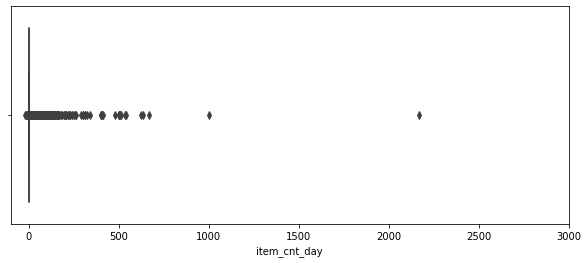

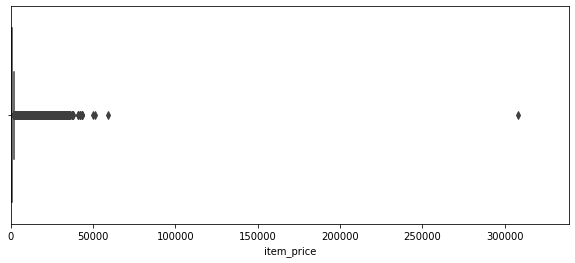

In [43]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [44]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

There is one item with price below zero. Fill it with median.

In [45]:
train.loc[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.00,1.00


In [46]:
# The item with price below zero is imputed by taking the mean of item- 2937 sold from shop 32 on 5th week
train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,2013-05-23,4,32,2973,1249.00,1.00
484684,2013-06-05,4,32,2973,2499.00,1.00


In [47]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [48]:
#pip install fuzzywuzzy

In [49]:
from fuzzywuzzy import fuzz, process

C:\Users\Abhishek\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [50]:
#Create tuples of shop names, matched shop names, and the score
score_sort = [(x,) + i
             for x in shops.shop_name 
             for i in process.extract(x, shops.shop_name, scorer=fuzz.token_sort_ratio)]


In [51]:
#Create a dataframe from the tuples
similarity_sort = pd.DataFrame(score_sort, columns=['name_sort','match_sort','score_sort', 'shop_no'])
similarity_sort.loc[(similarity_sort['score_sort'] != 100) & (similarity_sort['score_sort'] > 80)]

,name_sort,match_sort,score_sort,shop_no
1,"! Yakutsk Ordzhonikidze, 56 francs","Yakutsk Ordzhonikidze, 56",87,57
6,"! Yakutsk TC ""Central"" fran","Yakutsk TC ""Central""",88,58
116,"Moscow TK ""Budenovskiy"" (pav. A2)","Moscow TC ""Budenovskiy"" (pav. K7)",86,24
121,"Moscow TC ""Budenovskiy"" (pav. K7)","Moscow TK ""Budenovskiy"" (pav. A2)",86,23
286,"Yakutsk Ordzhonikidze, 56","! Yakutsk Ordzhonikidze, 56 francs",87,0
291,"Yakutsk TC ""Central""","! Yakutsk TC ""Central"" fran",88,1


- It is clear that shop no. 57 & 0, 58 & 1, 10 & 11 are same
- Shop no. 23 & 24 have same name but the location is different (pav A2 & pav K7)

In [52]:
# Yakutsk Ordzhonikidze, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Yakutsk shopping center "Central"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Zhukovsky st. Chkalov 39m²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [53]:
shops.loc[shops.shop_name == 'Sergiev Posad shopping center "7Ya"', 'shop_name'] = 'SergievPosad shopping center "7Ya"'

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '! Yakutsk', 'city'] = 'Yakutsk'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

In [54]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. The main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

In [55]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [56]:
#here we are making pair of shop_id and item_id -- month wise, whether it is purchased/returned or not
#all the pair of item and shops are there in each month
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

12.537460327148438

In [57]:
matrix.head()

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.

<i>I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.</i>

In [58]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

- item_cnt_month is clipped because in evaluation, it is stated that - Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

In [59]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

7.897320032119751

In [60]:
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.00
1,0,2,33,1.00
2,0,2,317,1.00
3,0,2,438,1.00
4,0,2,471,2.00


In [61]:
matrix.head(6)

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.00
1,0,2,27,1.00
2,0,2,28,0.00
3,0,2,29,0.00
4,0,2,32,0.00
5,0,2,33,1.00


## Test set
To use time tricks append test pairs to the matrix.

In [62]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [63]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.10672402381896973

## Shops/Items/Cats features

In [64]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

6.130603790283203

## Traget lags

In [65]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [66]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

42.82952284812927

In [67]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.00,1,40,13,20,nan,nan,nan,nan,nan
1,0,2,27,1.00,1,19,10,44,nan,nan,nan,nan,nan
2,0,2,28,0.00,1,30,16,55,nan,nan,nan,nan,nan
3,0,2,29,0.00,1,23,10,61,nan,nan,nan,nan,nan
4,0,2,32,0.00,1,40,13,20,nan,nan,nan,nan,nan


In [68]:
matrix.nunique()

date_block_num              35
shop_id                     57
item_id                  22169
item_cnt_month              21
city_code                   32
item_category_id            84
type_code                   24
subtype_code                65
item_cnt_month_lag_1        21
item_cnt_month_lag_2        21
item_cnt_month_lag_3        21
item_cnt_month_lag_6        21
item_cnt_month_lag_12       21
dtype: int64

## Mean encoded features

In [69]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.head()

,item_cnt_month
,mean
date_block_num,
0,0.35
1,0.32
2,0.36
3,0.28
4,0.27


In [70]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

12.64913558959961

In [71]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
0,0,2,19,0.00,1,40,13,20,nan,nan,nan,nan,nan,nan
1,0,2,27,1.00,1,19,10,44,nan,nan,nan,nan,nan,nan
2,0,2,28,0.00,1,30,16,55,nan,nan,nan,nan,nan,nan
3,0,2,29,0.00,1,23,10,61,nan,nan,nan,nan,nan,nan
4,0,2,32,0.00,1,40,13,20,nan,nan,nan,nan,nan,nan


In [72]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.head()

item_cnt_month
                                 mean
date_block_num item_id               
0              19                0.02
               27                0.16
               28                0.18
               29                0.09
               32                5.38

In [73]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

52.79981231689453

In [74]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

52.100685119628906

In [75]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

19.085959434509277

In [76]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

19.308367252349854

In [77]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

19.794069528579712

In [78]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

21.284087657928467

In [79]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

20.74353051185608

In [80]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

29.617801427841187

In [81]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

21.166399717330933

In [82]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

21.109554052352905

In [83]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,2,19,0.00,1,40,13,20,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0,2,27,1.00,1,19,10,44,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0,2,28,0.00,1,30,16,55,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0,2,29,0.00,1,23,10,61,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0,2,32,0.00,1,40,13,20,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.00,21,55,14,64,1.00,0.00,0.00,0.00,nan,0.26,0.05,0.02,0.07,0.59,nan,0.13,0.13,0.14,0.14,nan,0.20,0.13,0.09,0.13,0.14,0.50,0.15,0.20
11128000,34,45,16188,0.00,21,64,11,12,0.00,0.00,nan,nan,nan,0.26,0.02,0.07,nan,nan,nan,0.13,0.13,nan,nan,nan,0.16,0.09,0.11,0.09,0.14,0.00,0.24,0.16
11128001,34,45,15757,0.00,21,55,14,64,0.00,0.00,0.00,0.00,0.00,0.26,0.11,0.07,0.10,0.25,0.18,0.13,0.13,0.14,0.14,0.18,0.20,0.13,0.09,0.13,0.14,0.00,0.15,0.20
11128002,34,45,19648,0.00,21,40,13,20,0.00,0.00,0.00,0.00,nan,0.26,0.05,0.07,0.17,0.09,nan,0.13,0.13,0.14,0.14,nan,0.22,0.08,0.10,0.08,0.14,0.00,0.23,0.22


## Trend features

Price trend for the last six months.

In [107]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

336.10598039627075

In [108]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,delta_price_lag
0,0,2,19,0.00,1,40,13,20,nan,nan,nan,nan,nan,nan,0.00
1,0,2,27,1.00,1,19,10,44,nan,nan,nan,nan,nan,nan,0.00
2,0,2,28,0.00,1,30,16,55,nan,nan,nan,nan,nan,nan,0.00
3,0,2,29,0.00,1,23,10,61,nan,nan,nan,nan,nan,nan,0.00
4,0,2,32,0.00,1,40,13,20,nan,nan,nan,nan,nan,nan,0.00


Last month shop revenue trend

In [98]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

30.69497537612915

## Special features

In [99]:
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [100]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

<i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

In [104]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

1464.9904239177704

In [106]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale
0,0,2,19,0.00,1,40,13,20,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,0,31,-1
1,0,2,27,1.00,1,19,10,44,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,0,31,-1
2,0,2,28,0.00,1,30,16,55,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,0,31,-1
3,0,2,29,0.00,1,23,10,61,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,0,31,-1
4,0,2,32,0.00,1,40,13,20,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,0,31,-1


In [105]:
matrix.tail(50)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale
11127954,34,45,7572,0.00,21,64,11,12,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,10,30,-1
11127955,34,45,7925,0.00,21,7,0,62,nan,nan,0.00,0.00,1.00,nan,nan,nan,0.02,0.07,0.86,nan,nan,0.14,0.14,0.18,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,10,30,3
11127956,34,45,6117,0.00,21,30,16,55,0.00,0.00,0.00,0.00,1.00,0.26,0.05,0.12,0.21,0.20,0.26,0.13,0.13,0.14,0.14,0.18,0.59,0.30,0.17,0.30,0.14,0.00,0.33,0.59,-0.27,-0.29,10,30,1
11127957,34,45,6108,0.00,21,30,16,55,0.00,0.00,1.00,0.00,0.00,0.26,0.07,0.12,0.43,0.68,0.22,0.13,0.13,0.14,0.14,0.18,0.59,0.30,0.17,0.30,0.14,0.00,0.33,0.59,-0.64,-0.29,10,30,1
11127958,34,45,9030,0.00,21,40,13,20,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,10,30,-1
11127959,34,45,21425,0.00,21,38,6,11,nan,0.00,nan,nan,0.00,nan,nan,0.05,nan,nan,0.04,nan,0.13,nan,nan,0.18,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,10,30,2
11127960,34,45,3316,0.00,21,19,10,44,nan,nan,0.00,0.00,1.00,nan,nan,nan,0.07,0.02,0.92,nan,nan,0.14,0.14,0.18,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,10,30,3
11127961,34,45,19024,0.00,21,37,13,11,0.00,0.00,0.00,0.00,0.00,0.26,0.07,0.09,0.12,0.05,0.06,0.13,0.13,0.14,0.14,0.18,0.26,0.13,0.10,0.13,0.14,0.00,0.23,0.24,-0.54,-0.29,10,30,-1
11127962,34,45,6156,0.00,21,30,16,55,0.00,0.00,0.00,0.00,0.00,0.26,0.18,0.12,0.12,0.55,0.48,0.13,0.13,0.14,0.14,0.18,0.59,0.30,0.17,0.30,0.14,0.00,0.33,0.59,-0.28,-0.29,10,30,1
11127963,34,45,7972,0.00,21,33,18,35,0.00,0.00,0.00,0.00,0.00,0.26,0.02,0.07,0.10,0.16,0.10,0.13,0.13,0.14,0.14,0.18,1.30,1.33,1.08,1.33,0.14,0.00,1.77,1.30,-0.19,-0.29,10,30,1


In [115]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

990.4984986782074

Months since the first sale for each shop/item pair and for item only.

In [116]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

3.312741756439209

In [117]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
0,0,2,19,0.00,1,40,13,20,nan,nan,nan,nan,nan,nan,0.00,nan,0,31,-1,-1,0,0
1,0,2,27,1.00,1,19,10,44,nan,nan,nan,nan,nan,nan,0.00,nan,0,31,-1,-1,0,0
2,0,2,28,0.00,1,30,16,55,nan,nan,nan,nan,nan,nan,0.00,nan,0,31,-1,-1,0,0
3,0,2,29,0.00,1,23,10,61,nan,nan,nan,nan,nan,nan,0.00,nan,0,31,-1,-1,0,0
4,0,2,32,0.00,1,40,13,20,nan,nan,nan,nan,nan,nan,0.00,nan,0,31,-1,-1,0,0


## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [36]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

1.606701374053955

Producing lags brings a lot of nulls.

In [37]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

1.2636265754699707

In [38]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [39]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 40 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float16
city_code                               int8
item_category_id                        int8
type_code                               int8
subtype_code                            int8
item_cnt_month_lag_1                    float16
item_cnt_month_lag_2                    float16
item_cnt_month_lag_3                    float16
item_cnt_month_lag_6                    float16
item_cnt_month_lag_12                   float16
date_avg_item_cnt_lag_1                 float16
date_item_avg_item_cnt_lag_1            float16
date_item_avg_item_cnt_lag_2            float16
date_item_avg_item_cnt_lag_3            float16
date_item_avg_item_cnt_lag_6            float16
date_item_avg_item_cnt_lag_12       

In [40]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Part 2, xgboost

In [41]:
data = pd.read_pickle('data.pkl')

Select perfect features

In [42]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [43]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [44]:
del data
gc.collect();

In [45]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[19:40:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.05117	validation_1-rmse:1.04150
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.97137	validation_1-rmse:0.98203
[2]	validation_0-rmse:0.91683	validation_1-rmse:0.95044
[3]	validation_0-rmse:0.88316	validation_1-rmse:0.93185
[4]	validation_0-rmse:0.86404	validation_1-rmse:0.92559
[5]	validation_0-rmse:0.85318	validation_1-rmse:0.92290
[6]	validation_0-rmse:0.84525	validation_1-rmse:0.91835
[7]	validation_0-rmse:0.84057	validation_1-rmse:0.91666
[8]	validation_0-rmse:0.83581	validation_1-rmse:0.91353
[9]	validation_0-rmse:0.83249	validation_1-rmse:0.91272
[10]	validatio

718.6374957561493

In [46]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission1.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

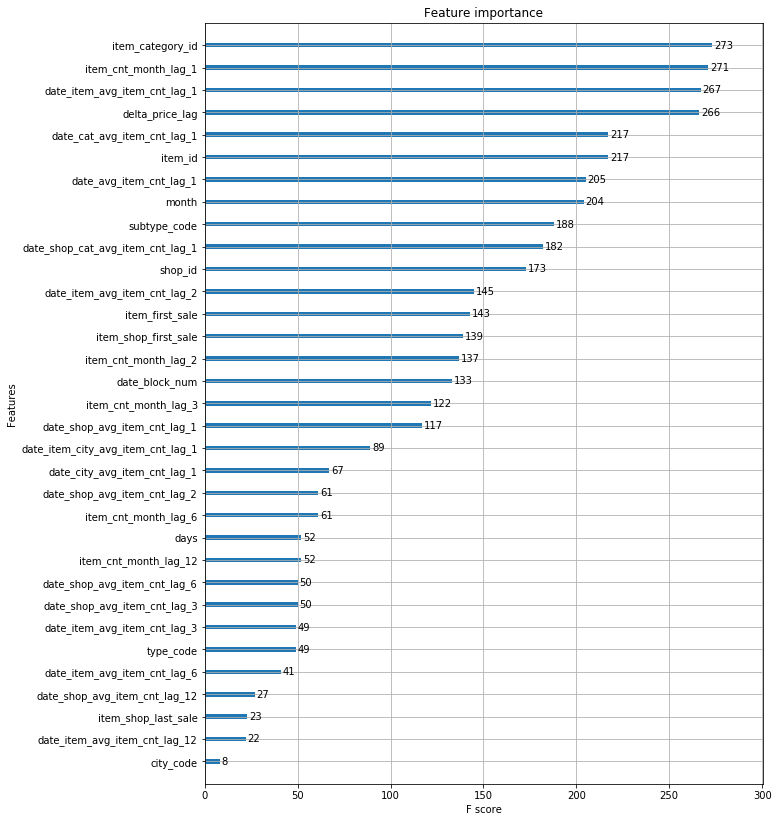

In [47]:
plot_features(model, (10,14))